**Завантажимо дані з Kaggle**

In [ ]:
# підключимо Google Диск до ноутбука Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# змінюємо поточну робочу директорію
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [ ]:
%ls

chest_xray/  chest-xray-pneumonia.zip  kaggle.json  test_model/


In [ ]:
%cd /content/drive/MyDrive/Kaggle/chest_xray/

/content/drive/MyDrive/Kaggle/chest_xray


In [ ]:
%ls

model10-1.pth  model11-4.pth  model6-2.pth  model6-7.pth  model8-4.pth  test/
model11-1.pth  model13-1.pth  model6-3.pth  model8-1.pth  model8-5.pth  train/
model11-2.pth  model14-1.pth  model6-5.pth  model8-2.pth  model8-6.pth
model11-3.pth  model6-1.pth   model6-6.pth  model8-3.pth  model9-1.pth


**Підключимо необхідні бібліотеки та завантажуємо дані**

In [ ]:
from tqdm.autonotebook import tqdm, trange
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# hyper-parameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001

In [ ]:
def equalize_image(image):
    return transforms.functional.equalize(image)

In [ ]:
# задаємо трансформації, які застосовуватимо для зображень
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((302, 302)),
        transforms.GaussianBlur((5, 5)),
        transforms.Lambda(equalize_image),
        transforms.RandomRotation(0.1),
        transforms.RandomAffine(degrees = 0, translate = (0.025, 0.025)),
        transforms.CenterCrop((300, 300)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.GaussianBlur((5, 5)),
        transforms.Lambda(equalize_image),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [ ]:
# задаємо директорію з даними
data_dir = '/content/drive/MyDrive/Kaggle/chest_xray'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# використовуємо клас DataLoader для завантаження даних у батчах
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], 
                                              batch_size=batch_size,
                                              shuffle=True, num_workers=2),
                'test': torch.utils.data.DataLoader(image_datasets['test'], 
                                              batch_size=batch_size,
                                              shuffle=False, num_workers=2)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
examples = iter(dataloaders['train']) # розмір батча, кількість каналів, і розмір картинки
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([128, 3, 300, 300]) torch.Size([128])


In [ ]:
# розміри train, test вибірок
print(dataset_sizes)

{'train': 5216, 'test': 624}


In [ ]:
for _set in ['train', 'test']:
    n_normal = len(os.listdir(data_dir + '/' + _set + '/NORMAL'))
    n_infect = len(os.listdir(data_dir + '/' + _set + '/PNEUMONIA'))
    n = dataset_sizes[_set]
    print(f'Набір: {_set}', f'-всього зображень: {n}', 
          f'-NORMAL: {n_normal}',
          f'-PNEUMONIA: {n_infect}', sep='\n')

Набір: train
-всього зображень: 5216
-NORMAL: 1341
-PNEUMONIA: 3875
Набір: test
-всього зображень: 624
-NORMAL: 234
-PNEUMONIA: 390


In [ ]:
inputs, classes = next(iter(dataloaders['train']))
print("Розмір зображення: ", inputs[0].numpy().shape)
print("Мітка: ", class_names[classes[0].numpy()])

Розмір зображення:  (3, 300, 300)
Мітка:  PNEUMONIA


**Візуалізуємо дані**

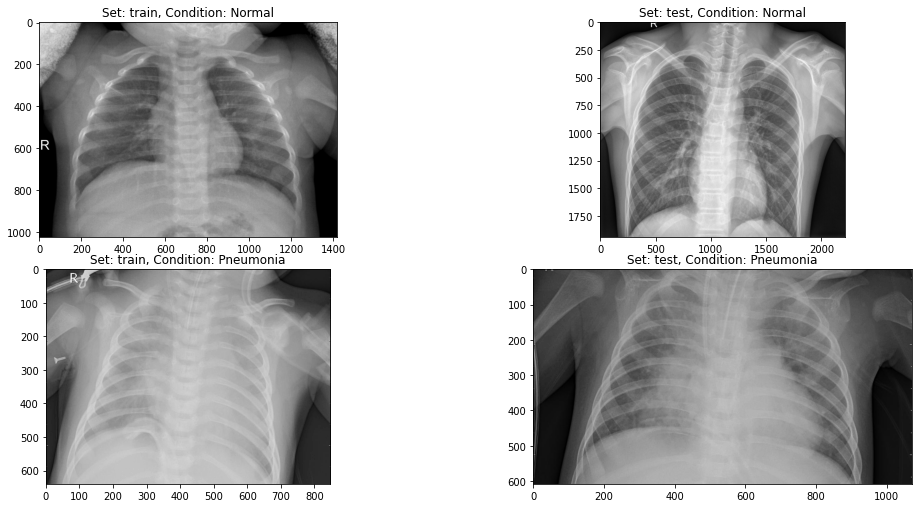

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = data_dir + '/' + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+
                            os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/PNEUMONIA/'+
                            os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Pneumonia'.format(_set))    

**Візуалізуємо один батч, розмірність якого 128 зображень**

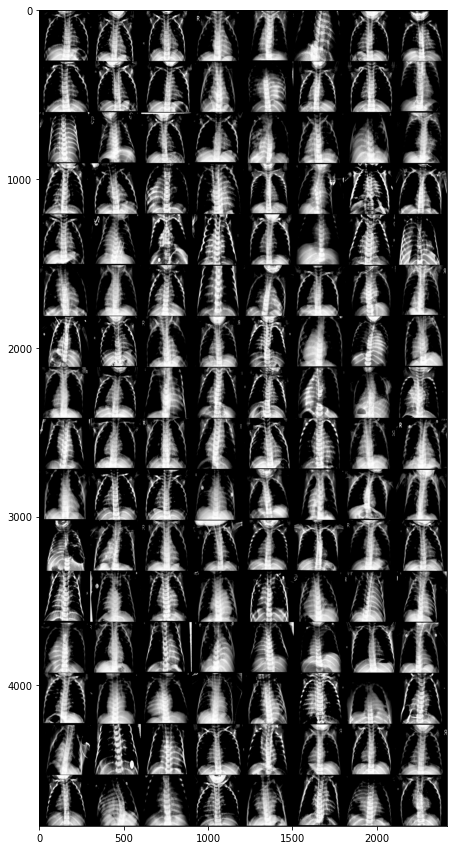

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# отримаємо один бачт з train набору
inputs, classes = next(iter(dataloaders['train']))

# зобразимо зображення поряд
out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])
imshow(out)

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(16):
        ax = plt.subplot(4, 4,n+1)
        plt.imshow(np.transpose(image_batch[n], (1, 2, 0)))
        if label_batch[n]:
            plt.title("PNEUMONIA", fontsize='20')
        else:
            plt.title("NORMAL", fontsize='20')
        plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

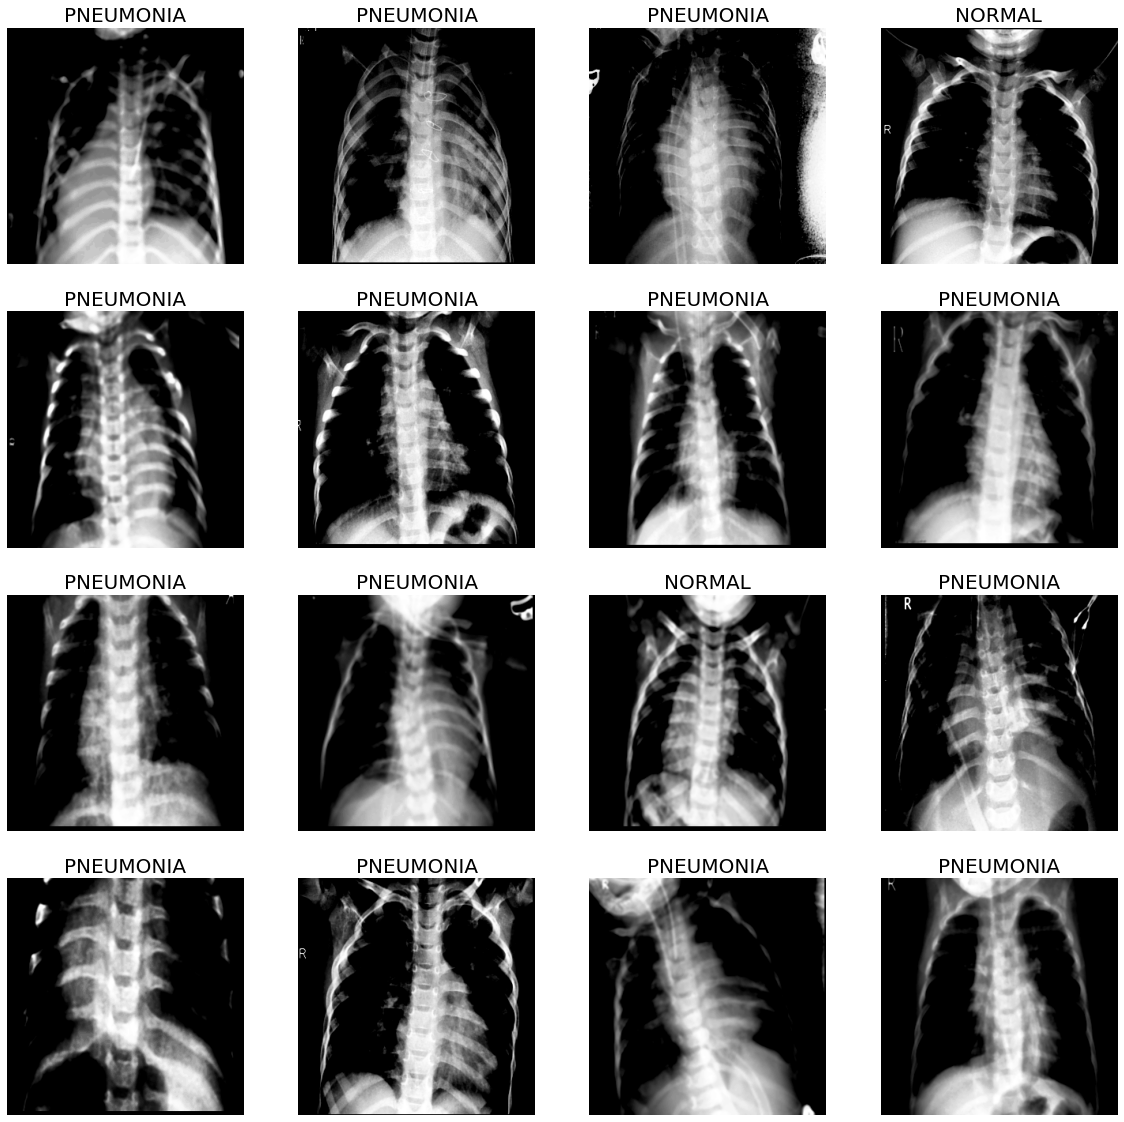

In [ ]:
np_images = inputs.numpy()
np_classes = classes.numpy()
show_batch(np_images, np_classes)

**Створення моделі**

In [ ]:
# implement Conv Network
class ChestX_raysNet(nn.Module):
  def __init__(self):
    super(ChestX_raysNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
    self.fc1 = nn.Linear(64*7*7, 512)
    self.fc2 = nn.Linear(512, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = self.pool(F.relu(self.conv5(x)))
    # Flatten Tensor
    x = x.view(-1, 64*7*7)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

Перевірка скільки нейронів буде першому лінійному шарі

In [ ]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
print(images.shape)
conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv3(x)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv4(x)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv5(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([128, 3, 300, 300])
torch.Size([128, 16, 298, 298])
torch.Size([128, 16, 149, 149])
torch.Size([128, 32, 147, 147])
torch.Size([128, 32, 73, 73])
torch.Size([128, 64, 71, 71])
torch.Size([128, 64, 35, 35])
torch.Size([128, 64, 33, 33])
torch.Size([128, 64, 16, 16])
torch.Size([128, 64, 14, 14])
torch.Size([128, 64, 7, 7])


In [ ]:
model = ChestX_raysNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
n_total_steps = len(dataloaders['train'])
print(n_total_steps)

41


**Навчання моделі**

In [ ]:
n_total_steps = len(dataloaders['train'])
since = time.time()
train_losses = []
valid_accuracies = []
for epoch in range(num_epochs):
  loss_sum = 0
  for i, (images, labels) in enumerate(dataloaders['train']):
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_sum += loss.item()

    # backward and optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 20 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], '
      f'Loss [{loss.item():.4f}]')

  train_losses.append(loss_sum / n_total_steps)
  
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'
.format(time_elapsed // 60, time_elapsed % 60))

Epoch [1/10], Step [20/41], Loss [0.3111]
Epoch [1/10], Step [40/41], Loss [0.2325]
Epoch [2/10], Step [20/41], Loss [0.1449]
Epoch [2/10], Step [40/41], Loss [0.1715]
Epoch [3/10], Step [20/41], Loss [0.1479]
Epoch [3/10], Step [40/41], Loss [0.0960]
Epoch [4/10], Step [20/41], Loss [0.1520]
Epoch [4/10], Step [40/41], Loss [0.0836]
Epoch [5/10], Step [20/41], Loss [0.0641]
Epoch [5/10], Step [40/41], Loss [0.0876]
Epoch [6/10], Step [20/41], Loss [0.0446]
Epoch [6/10], Step [40/41], Loss [0.0745]
Epoch [7/10], Step [20/41], Loss [0.1241]
Epoch [7/10], Step [40/41], Loss [0.1004]
Epoch [8/10], Step [20/41], Loss [0.0499]
Epoch [8/10], Step [40/41], Loss [0.1210]
Epoch [9/10], Step [20/41], Loss [0.0798]
Epoch [9/10], Step [40/41], Loss [0.0668]
Epoch [10/10], Step [20/41], Loss [0.0376]
Epoch [10/10], Step [40/41], Loss [0.1553]
Training complete in 19m 57s


**Графік loss**

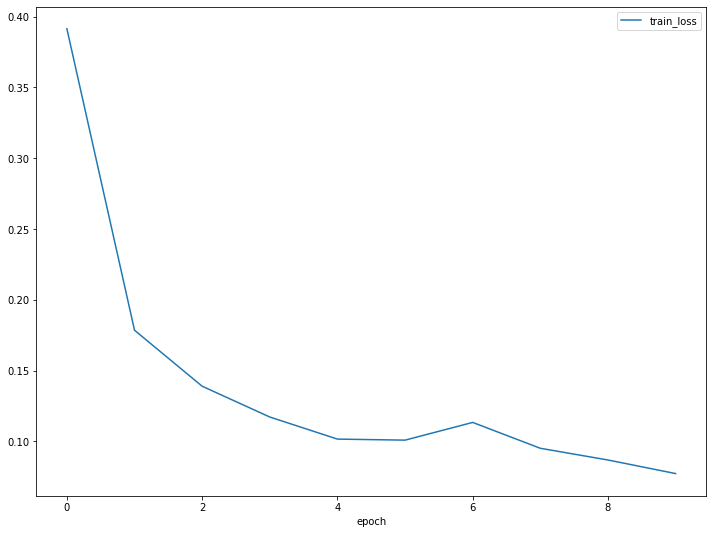

In [ ]:
plt.figure(figsize=(12, 9))
plt.xlabel("epoch")
plt.plot(train_losses, label="train_loss")
plt.legend()

**Оцінка моделі**

In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    # value and index 
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predictions == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'accuracy = {acc}')

accuracy = 83.81410256410257


In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in dataloaders['train']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    # value and index 
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predictions == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'accuracy = {acc}')

accuracy = 96.875


**Збереження моделі**

In [ ]:
FILE = "/content/drive/MyDrive/Kaggle/chest_xray/model8-6.pth"
torch.save(model.state_dict(), FILE)
# print(model.state_dict())
# loaded_model = Model(n_input_features=6)
# loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
# loaded_model.eval()

# print(loaded_model.state_dict()

**Використання моделі для передбачень**

In [ ]:
# allow user to upload the image to predict
from google.colab import files

uploaded = files.upload()

Saving round-pneumonia-2.jpg to round-pneumonia-2 (1).jpg


Завантажимо натреновану модель

In [ ]:
FILE = "/content/drive/MyDrive/Kaggle/chest_xray/model8-6.pth"
device = torch.device('cpu')
loaded_model = ChestX_raysNet()
loaded_model.load_state_dict(torch.load(FILE, map_location=device))
# loaded_model.to(device)
loaded_model.eval()

ChestX_raysNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
from PIL import Image
import io

def transform_image(image):
  transform = transforms.Compose([                       
        transforms.Resize((300, 300)),
        transforms.GaussianBlur((5, 5)),
        transforms.Lambda(equalize_image),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  image = transform(image)
  return torch.stack([image])

In [ ]:
def get_prediction(image_tensor):
  images = image_tensor.to(device)
  outputs = loaded_model(images)
  _, predictions = torch.max(outputs.data, 1)
  return predictions

In [ ]:
def predict():
  plt.figure(figsize=(20,20))
  for img in uploaded.keys():
    image_index = list(uploaded.keys()).index(img)
    img_path = '/content/' + img
    image = Image.open(img_path).convert('RGB')
    img_to_predict = image
    tensor = transform_image(img_to_predict)
    prediction = get_prediction(tensor)
    data = {'prediction:': prediction.item(), 
            'class_name': class_names[prediction.item()]}
    ax = plt.subplot(1, len(list(uploaded.keys())), image_index+1)
    plt.imshow(img_to_predict)
    if prediction.item():
      plt.title(img + ' is PNEUMONIA')
    else:
      plt.title(img + ' is NORMAL')

**Модель для виявлення пневмонії на рентгенівських зображеннях легень.**

In [ ]:
#@title Завантаження зображень.
# allow user to upload the image to predict
from google.colab import files

uploaded = files.upload()

Saving bronchopneumonia.png to bronchopneumonia.png


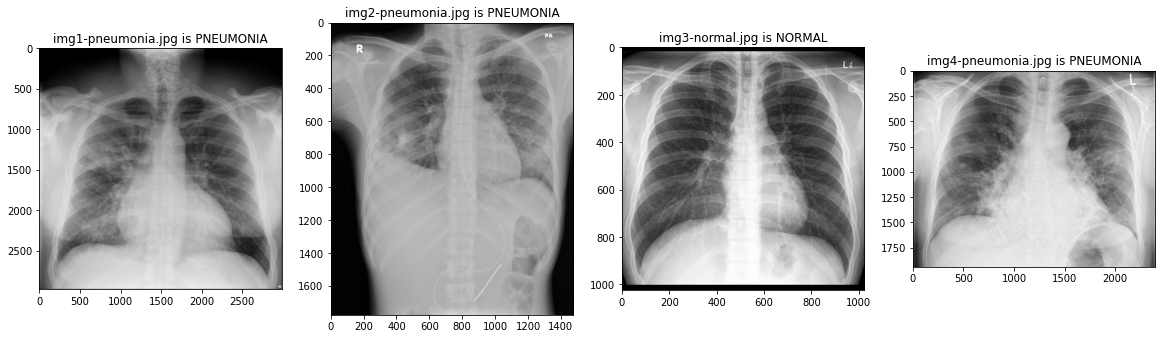

In [ ]:
#@title Результат роботи моделі.
predict()